82 3
EPV calculations saved to epv.xlsx


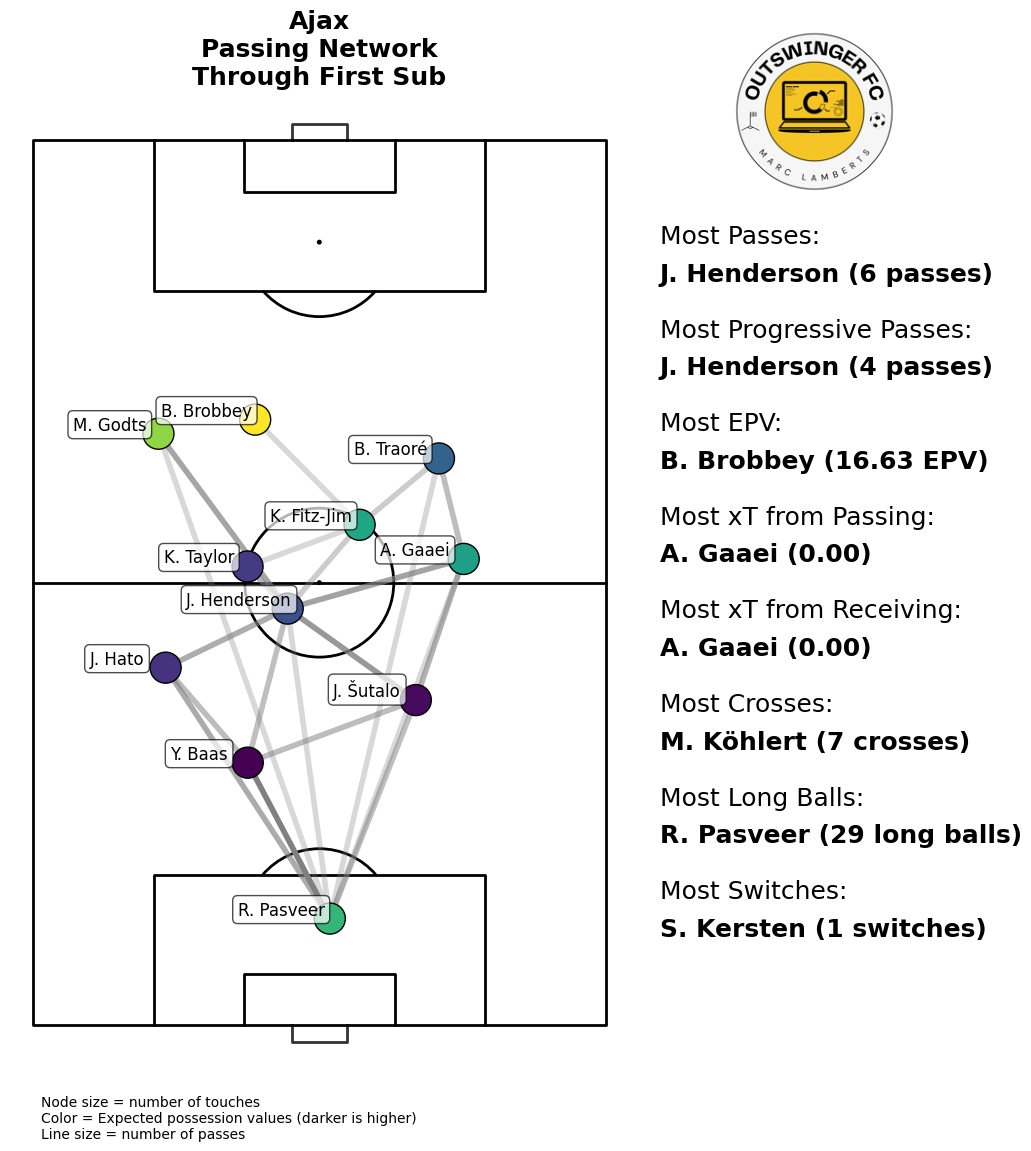

In [136]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from mplsoccer import VerticalPitch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Function to add logo to the plot
def add_logo(ax, logo_path):
    # Load the logo image
    logo = mpimg.imread(logo_path)
    
    # Create an OffsetImage object for the logo
    imagebox = OffsetImage(logo, zoom=0.7)  # Adjust zoom for desired size
    
    # Position the logo at the top-right corner
    ab = AnnotationBbox(imagebox, (1.3, 1), frameon=False, 
                        xycoords='axes fraction', boxcoords="axes fraction")
    
    # Add the logo as an artist to the plot
    ax.add_artist(ab)

# Plotting function with logo added only to the right pitch
def plot_pass_network_with_logo(ax, pitch, average_locs_and_count, passes_between, title, add_logo_to_this_plot=False, logo_path=None):
    # Draw the pitch
    pitch.draw(ax=ax)

    # Normalize counts for coloring
    norm = Normalize(vmin=average_locs_and_count['epv'].min(), vmax=average_locs_and_count['epv'].max())
    cmap = plt.cm.viridis
    colors = cmap(norm(average_locs_and_count['epv']))

    # Normalize pass counts for zorder and alpha
    max_pass_count = passes_between['pass_count'].max()
    passes_between['zorder'] = passes_between['pass_count'] / max_pass_count * 10
    passes_between['alpha'] = passes_between['pass_count'] / max_pass_count

    # Draw pass lines without arrowheads
    for index, row in passes_between.iterrows():
        pitch.lines(row['x'], row['y'], row['x_end'], row['y_end'],
                    color='grey', alpha=row['alpha'], lw=4, ax=ax, zorder=row['zorder'])

    # Plot larger nodes with colors based on EPV values
    pitch.scatter(average_locs_and_count['x'], average_locs_and_count['y'], s=500,  # Increased size
                  color=colors, edgecolors="black", linewidth=1, alpha=1, ax=ax, zorder=11)

    # Annotate player names with offsets to avoid overlap with nodes
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(row.name, xy=(row.x, row.y), ax=ax, ha='center', va='bottom',
                       fontsize=12, color='black', zorder=12, xytext=(0, -35), textcoords='offset points',
                       bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7))

    # Set title
    ax.set_title(title, fontsize=18, color="black", fontweight='bold', pad=20)

    # Add logo to the right plot if the flag is set
    if add_logo_to_this_plot:
        add_logo(ax, logo_path)

# Load data
df = pd.read_excel("Pass.xlsx")

# Import EPV grid
epv = pd.read_csv("epv_grid.csv", header=None)  # Assuming epv_grid.csv was saved earlier
epv = np.array(epv)  # Convert to numpy array
epv_rows, epv_cols = epv.shape  # Get rows and columns
print(epv_rows, epv_cols)

# Load xT data
xt_df = pd.read_excel("xT.xlsx")  # xT.xlsx should contain xT values for different pitch zones

# Ensure coordinate columns are numeric
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

# Check for missing or invalid values in the coordinates
if df[['x', 'y', 'endX', 'endY']].isnull().any().any():
    print("Warning: There are missing or invalid values in the coordinates. Check your data.")

# Map start and end coordinates to EPV zones
df['x1_bin'] = pd.cut(df['x'], bins=epv_cols, labels=False).astype('Int64')
df['y1_bin'] = pd.cut(df['y'], bins=epv_rows, labels=False).astype('Int64')
df['x2_bin'] = pd.cut(df['endX'], bins=epv_cols, labels=False).astype('Int64')
df['y2_bin'] = pd.cut(df['endY'], bins=epv_rows, labels=False).astype('Int64')

# Calculate start and end zone EPV values, ensuring numeric conversion
def get_epv_value(bin_indices, epv_grid):
    if pd.notnull(bin_indices[0]) and pd.notnull(bin_indices[1]):
        return epv_grid[int(bin_indices[1])][int(bin_indices[0])]
    return np.nan  # Return NaN if indices are invalid

df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)

# Ensure the EPV values are numeric
df['start_zone_value'] = pd.to_numeric(df['start_zone_value'], errors='coerce')
df['end_zone_value'] = pd.to_numeric(df['end_zone_value'], errors='coerce')

# Compute EPV for the action
df['epv'] = df['end_zone_value'] - df['start_zone_value']

# Save the results to an Excel file
df.to_excel("epv.xlsx", index=False)
print("EPV calculations saved to epv.xlsx")

# Define a function to create pass network data for a team
def create_pass_network_data(df, team_id):
    # Filter the data for the given team
    team_data = df.loc[(df['contestantId'] == team_id)].reset_index()

    # Create a new column for time in seconds
    team_data["newsecond"] = 60 * team_data["timeMin"] + team_data["timeSec"]
    team_data.sort_values(by=['newsecond'], inplace=True)

    # Identify the passer and recipient
    team_data['passer'] = team_data['playerName']
    team_data['recipient'] = team_data['passer'].shift(-1)

    # Filter for only passes and successful passes
    passes = team_data.loc[(team_data['typeId'] == 1)]
    completions = passes.loc[(passes['outcome'] == 1)]

    # Find the time of the team's first substitution and filter passes before that
    subs = team_data.loc[(team_data['typeId'] == 18)]
    sub_times = subs["newsecond"]
    sub_one = sub_times.min()
    completions = completions.loc[completions['newsecond'] < sub_one]

    # Calculate average locations and count of passes
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean'], 'epv': ['mean']})
    average_locs_and_count.columns = ['x', 'y', 'epv']

    # Calculate passes between players
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

    # Filter for minimal 3 passes in combinations
    passes_between = passes_between.loc[passes_between['pass_count'] >= 3]

    return average_locs_and_count, passes_between

# Create data for one team
team_id = 'd0zdg647gvgc95xdtk1vpbkys'  # Ajax (change this to the team you're interested in)
data_team = create_pass_network_data(df, team_id)

# Calculate metrics
# 1. Most Passes
most_passes_player = data_team[1].groupby('passer').size().idxmax()
most_passes_count = data_team[1].groupby('passer').size().max()

# 2. Most Progressive Passes
# Assuming progressive passes are simply the passes in the forward direction (example: passes with endY > startY)
data_team[1]['is_progressive'] = data_team[1]['y_end'] > data_team[1]['y']
most_progressive_player = data_team[1].groupby('passer')['is_progressive'].sum().idxmax()
most_progressive_count = data_team[1].groupby('passer')['is_progressive'].sum().max()

# 3. Most EPV
most_epv_player = data_team[0]['epv'].idxmax()
most_epv_value = data_team[0]['epv'].max()

# 4. Calculate xT for passing and receiving
def get_xt_value(x, y, xt_df):
    return xt_df.loc[(xt_df['x'] == x) & (xt_df['y'] == y), 'xT'].values[0] if not xt_df.loc[(xt_df['x'] == x) & (xt_df['y'] == y)].empty else np.nan

# Calculate xT for passes and receptions
data_team[1]['passer_xT'] = data_team[1].apply(lambda row: get_xt_value(row['x'], row['y'], xt_df), axis=1)
data_team[1]['recipient_xT'] = data_team[1].apply(lambda row: get_xt_value(row['x_end'], row['y_end'], xt_df), axis=1)

# Calculate Most xT from Passing and Receiving
most_xt_from_passing = data_team[1].groupby('passer')['passer_xT'].sum().idxmax()
most_xt_from_passing_value = data_team[1].groupby('passer')['passer_xT'].sum().max()

most_xt_from_receiving = data_team[1].groupby('recipient')['recipient_xT'].sum().idxmax()
most_xt_from_receiving_value = data_team[1].groupby('recipient')['recipient_xT'].sum().max()

# Set up the single vertical pitch
fig, ax = plt.subplots(figsize=(16, 12))
fig.set_facecolor("white")

# Create vertical pitch
pitch = VerticalPitch(pitch_type='opta', pad_top=5, pitch_color='white', line_color='black',
                      half=False, goal_type='box', goal_alpha=0.8)

# Path to the logo
logo_path = 'Outswinger FC (3).png'  # Replace with your logo path

# Plot the pass network for the selected team (with logo)
plot_pass_network_with_logo(ax, pitch, data_team[0], data_team[1], f"Ajax\nPassing Network\nThrough First Sub", add_logo_to_this_plot=True, logo_path=logo_path)

# Calculate metrics for Cross, LongBall, and Switch
most_crosses_player = df.loc[df['Cross'] == 1, 'playerName'].value_counts().idxmax()
most_crosses_count = df.loc[df['Cross'] == 1, 'playerName'].value_counts().max()

most_longballs_player = df.loc[df['LongBall'] == 1, 'playerName'].value_counts().idxmax()
most_longballs_count = df.loc[df['LongBall'] == 1, 'playerName'].value_counts().max()

most_switches_player = df.loc[df['Switch'] == 1, 'playerName'].value_counts().idxmax()
most_switches_count = df.loc[df['Switch'] == 1, 'playerName'].value_counts().max()

# Add the metrics text to the plot with player names in bold and placed under the metrics
ax.text(1.05, 0.88, f"Most Passes:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')
ax.text(1.05, 0.78, f"Most Progressive Passes:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')
ax.text(1.05, 0.68, f"Most EPV:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')

# Add player names in bold and under the metrics
ax.text(1.05, 0.84, f"{most_passes_player} ({most_passes_count} passes)", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')
ax.text(1.05, 0.74, f"{most_progressive_player} ({most_progressive_count} passes)", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')
ax.text(1.05, 0.64, f"{most_epv_player} ({most_epv_value:.2f} EPV)", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')

# Add xT text annotations with larger size and placed under the metrics
ax.text(1.05, 0.58, f"Most xT from Passing:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')
ax.text(1.05, 0.48, f"Most xT from Receiving:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')

# Add player names in bold and under the xT metrics
ax.text(1.05, 0.54, f"{most_xt_from_passing} ({most_xt_from_passing_value:.2f})", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')
ax.text(1.05, 0.44, f"{most_xt_from_receiving} ({most_xt_from_receiving_value:.2f})", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')

# Add Cross, LongBall, and Switch metrics
ax.text(1.05, 0.38, f"Most Crosses:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')
ax.text(1.05, 0.28, f"Most Long Balls:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')
ax.text(1.05, 0.18, f"Most Switches:", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='normal')

# Add player names in bold and under the metrics
ax.text(1.05, 0.34, f"{most_crosses_player} ({most_crosses_count} crosses)", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')
ax.text(1.05, 0.24, f"{most_longballs_player} ({most_longballs_count} long balls)", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')
ax.text(1.05, 0.14, f"{most_switches_player} ({most_switches_count} switches)", transform=ax.transAxes, fontsize=18, ha='left', va='top', fontweight='bold')

# Adjust spacing and add explanatory text below the pitch
plt.subplots_adjust(bottom=0.1)  # Increase the bottom margin to give space for the text

# Add explanatory text at the bottom
ax.text(0.05, -0.05, 'Node size = number of touches\nColor = Expected possession values (darker is higher)\nLine size = number of passes',
        transform=ax.transAxes, fontsize=10, color='black', ha='left', va='top', fontweight='normal')

# Save and show the plot
plt.savefig('Passnetwork_with_logo_and_metrics_and_xT_and_additional_metrics.png', dpi=500, bbox_inches='tight', facecolor='white')
plt.show()





82 3
EPV calculations saved to epv.xlsx


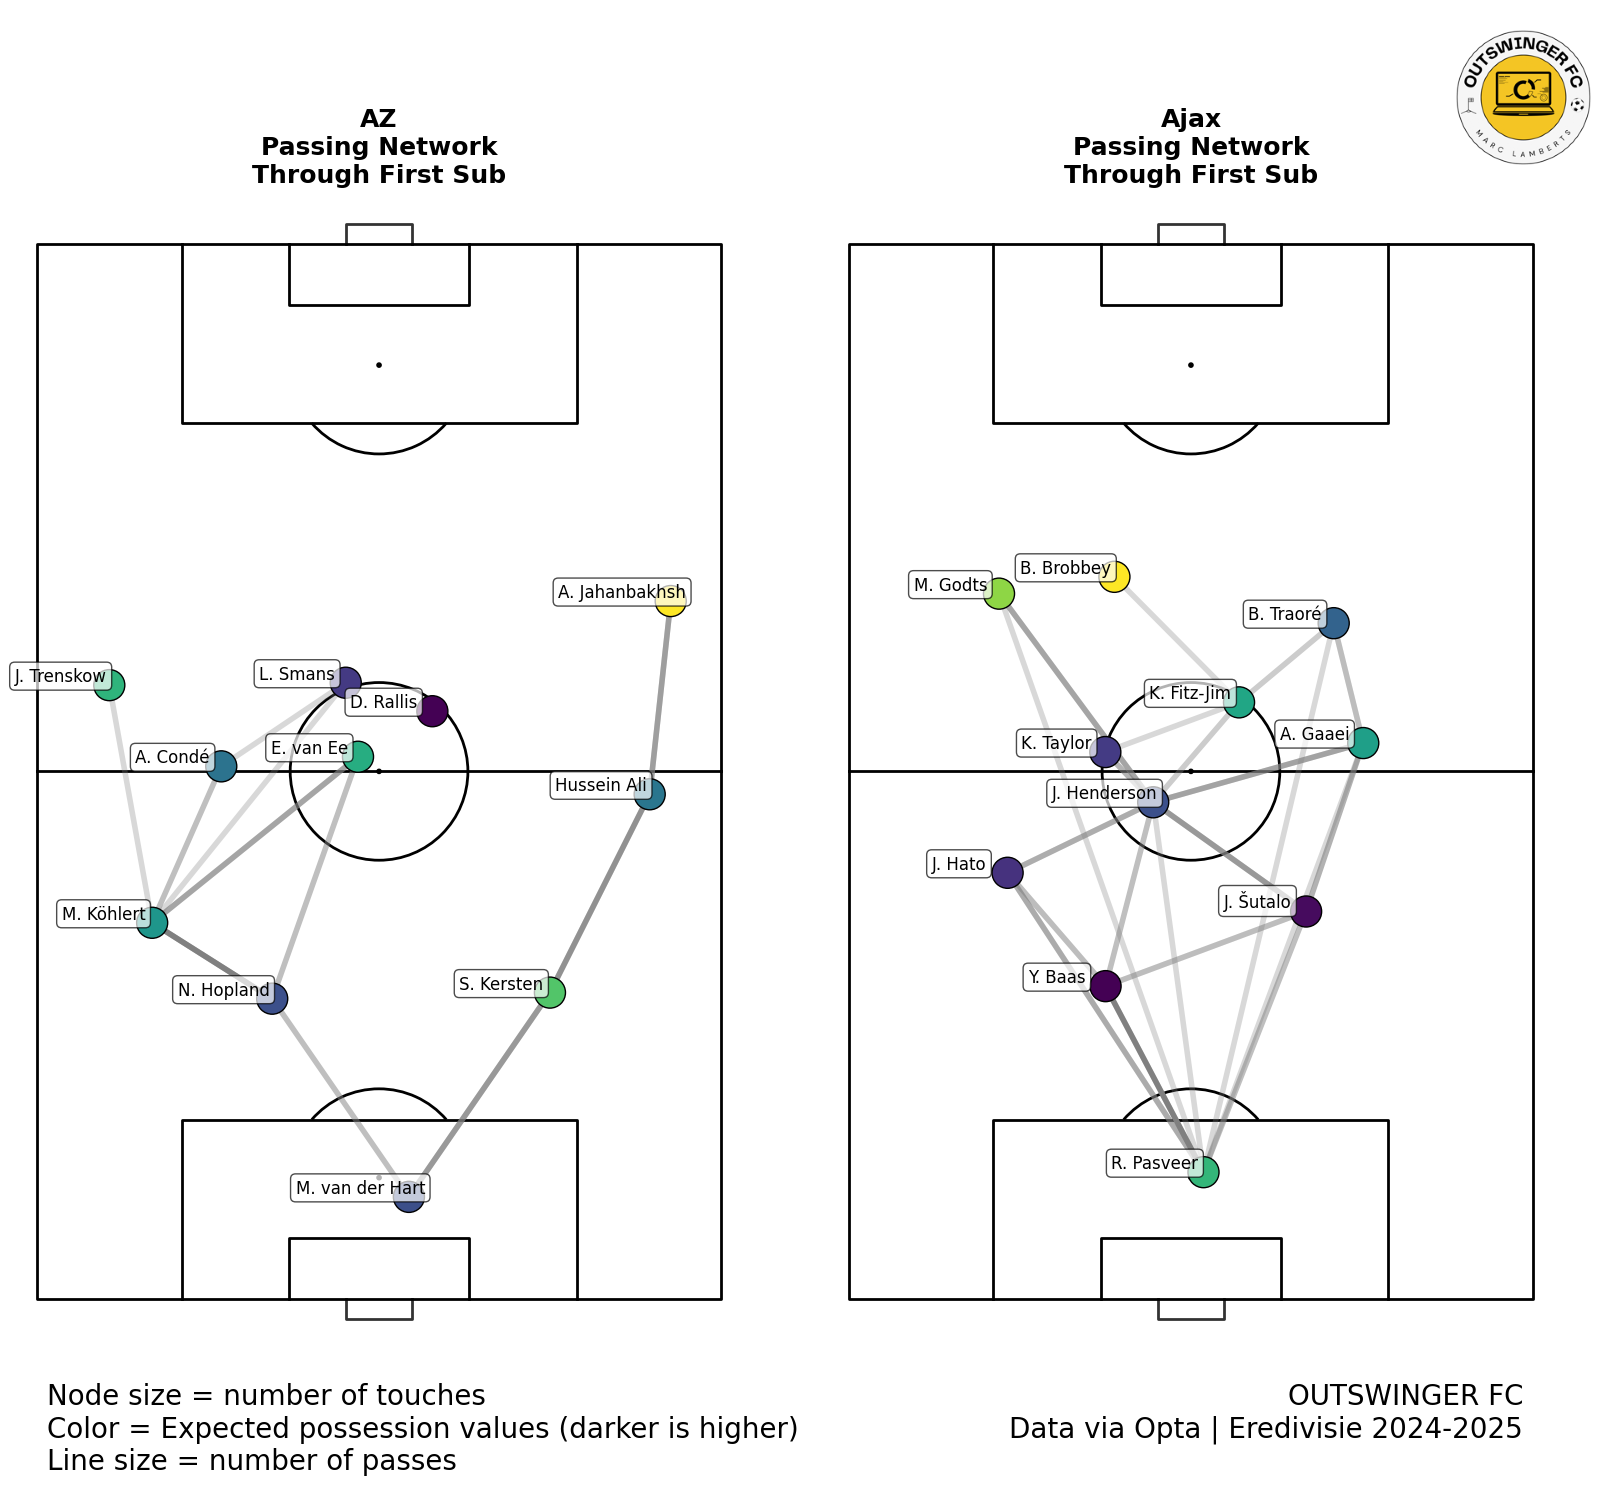

In [100]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from mplsoccer import VerticalPitch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Function to add logo to the plot
def add_logo(ax, logo_path):
    # Load the logo image
    logo = mpimg.imread(logo_path)
    
    # Create an OffsetImage object for the logo
    imagebox = OffsetImage(logo, zoom=0.6)  # Increased zoom for a bigger logo
    
    # Position the logo at the top-right corner with a higher position
    ab = AnnotationBbox(imagebox, (0.95, 1.1), frameon=False, 
                        xycoords='axes fraction', boxcoords="axes fraction")
    
    # Add the logo as an artist to the plot
    ax.add_artist(ab)

# Plotting function with logo added only to the second (right) pitch
def plot_pass_network_with_logo(ax, pitch, average_locs_and_count, passes_between, title, add_logo_to_this_plot=False, logo_path=None):
    # Draw the pitch
    pitch.draw(ax=ax)

    # Normalize counts for coloring
    norm = Normalize(vmin=average_locs_and_count['epv'].min(), vmax=average_locs_and_count['epv'].max())
    cmap = plt.cm.viridis
    colors = cmap(norm(average_locs_and_count['epv']))

    # Normalize pass counts for zorder and alpha
    max_pass_count = passes_between['pass_count'].max()
    passes_between['zorder'] = passes_between['pass_count'] / max_pass_count * 10
    passes_between['alpha'] = passes_between['pass_count'] / max_pass_count

    # Draw pass lines without arrowheads
    for index, row in passes_between.iterrows():
        pitch.lines(row['x'], row['y'], row['x_end'], row['y_end'],
                    color='grey', alpha=row['alpha'], lw=4, ax=ax, zorder=row['zorder'])

    # Plot larger nodes with colors based on EPV values
    pitch.scatter(average_locs_and_count['x'], average_locs_and_count['y'], s=500,  # Increased size
                  color=colors, edgecolors="black", linewidth=1, alpha=1, ax=ax, zorder=11)

    # Annotate player names with offsets to avoid overlap with nodes
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(row.name, xy=(row.x, row.y), ax=ax, ha='center', va='bottom',
                       fontsize=12, color='black', zorder=12, xytext=(0, -35), textcoords='offset points',
                       bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7))

    # Set title
    ax.set_title(title, fontsize=18, color="black", fontweight='bold', pad=20)

    # Add logo to the right plot if the flag is set
    if add_logo_to_this_plot:
        add_logo(ax, logo_path)

# Load data
df = pd.read_excel("Pass.xlsx")

# Import EPV grid
epv = pd.read_csv("epv_grid.csv", header=None)  # Assuming epv_grid.csv was saved earlier
epv = np.array(epv)  # Convert to numpy array
epv_rows, epv_cols = epv.shape  # Get rows and columns
print(epv_rows, epv_cols)

# Ensure coordinate columns are numeric
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

# Check for missing or invalid values in the coordinates
if df[['x', 'y', 'endX', 'endY']].isnull().any().any():
    print("Warning: There are missing or invalid values in the coordinates. Check your data.")

# Map start and end coordinates to EPV zones
df['x1_bin'] = pd.cut(df['x'], bins=epv_cols, labels=False).astype('Int64')
df['y1_bin'] = pd.cut(df['y'], bins=epv_rows, labels=False).astype('Int64')
df['x2_bin'] = pd.cut(df['endX'], bins=epv_cols, labels=False).astype('Int64')
df['y2_bin'] = pd.cut(df['endY'], bins=epv_rows, labels=False).astype('Int64')

# Calculate start and end zone EPV values, ensuring numeric conversion
def get_epv_value(bin_indices, epv_grid):
    if pd.notnull(bin_indices[0]) and pd.notnull(bin_indices[1]):
        return epv_grid[int(bin_indices[1])][int(bin_indices[0])]
    return np.nan  # Return NaN if indices are invalid

df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)

# Ensure the EPV values are numeric
df['start_zone_value'] = pd.to_numeric(df['start_zone_value'], errors='coerce')
df['end_zone_value'] = pd.to_numeric(df['end_zone_value'], errors='coerce')

# Compute EPV for the action
df['epv'] = df['end_zone_value'] - df['start_zone_value']

# Save the results to an Excel file
df.to_excel("epv.xlsx", index=False)
print("EPV calculations saved to epv.xlsx")

# Define a function to create pass network data for a team
def create_pass_network_data(df, team_id):
    # Filter the data for the given team
    team_data = df.loc[(df['contestantId'] == team_id)].reset_index()

    # Create a new column for time in seconds
    team_data["newsecond"] = 60 * team_data["timeMin"] + team_data["timeSec"]
    team_data.sort_values(by=['newsecond'], inplace=True)

    # Identify the passer and recipient
    team_data['passer'] = team_data['playerName']
    team_data['recipient'] = team_data['passer'].shift(-1)

    # Filter for only passes and successful passes
    passes = team_data.loc[(team_data['typeId'] == 1)]
    completions = passes.loc[(passes['outcome'] == 1)]

    # Find the time of the team's first substitution and filter passes before that
    subs = team_data.loc[(team_data['typeId'] == 18)]
    sub_times = subs["newsecond"]
    sub_one = sub_times.min()
    completions = completions.loc[completions['newsecond'] < sub_one]

    # Calculate average locations and count of passes
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count'], 'epv': ['mean']})
    average_locs_and_count.columns = ['x', 'y', 'count', 'epv']

    # Calculate passes between players
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

    # Filter for minimal 3 passes in combinations
    passes_between = passes_between.loc[passes_between['pass_count'] >= 3]

    return average_locs_and_count, passes_between

# Create data for both teams
team1_id = '4vd2t5schmvvufrfib7f2vjdf'  # AZ
team2_id = 'd0zdg647gvgc95xdtk1vpbkys'  # Ajax

data_team1 = create_pass_network_data(df, team1_id)
data_team2 = create_pass_network_data(df, team2_id)

# Set up the two vertical pitches side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 16), gridspec_kw={'wspace': 0.1})
fig.set_facecolor("white")

# Create vertical pitch
pitch = VerticalPitch(pitch_type='opta', pad_top=5, pitch_color='white', line_color='black',
                      half=False, goal_type='box', goal_alpha=0.8)

# Path to the logo
logo_path = 'Outswinger FC (3).png'  # Replace with your logo path

# Plot the pass network for AZ (no logo)
plot_pass_network_with_logo(axs[0], pitch, data_team1[0], data_team1[1], "AZ\nPassing Network\nThrough First Sub", add_logo_to_this_plot=False)

# Plot the pass network for Ajax (with logo)
plot_pass_network_with_logo(axs[1], pitch, data_team2[0], data_team2[1], "Ajax\nPassing Network\nThrough First Sub", add_logo_to_this_plot=True, logo_path=logo_path)

# Adjust spacing and add explanatory text below each pitch
plt.subplots_adjust(bottom=0.15)  # Increase the bottom margin to give space for the text
axs[0].text(0.05, -0.05, 'Node size = number of touches\nColor = Expected possession values (darker is higher)\nLine size = number of passes',
            transform=axs[0].transAxes, fontsize=20, color='black', ha='left', va='top', fontweight='normal')

axs[1].text(0.95, -0.05, 'OUTSWINGER FC\nData via Opta | Eredivisie 2024-2025',
            transform=axs[1].transAxes, fontsize=20, color='black', ha='right', va='top', fontweight='normal')

# Save and show the plot
plt.savefig('Passnetwork_AZ_vs_Ajax_with_logo_on_right_pitch.png', dpi=500, bbox_inches='tight', facecolor='white')
plt.show()
